[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/1-Transductive-Rewiring.ipynb)

# Transductive Rewiring
Francisco Escolano, ELLIS Alicante UNIT

Adrián Arnaiz Rodríguez, ELLIS Alicante UNIT

Ahmed Begga, University of Valencia

***Tutorial on Graph Rewiring: From Theory to Applications in Fairness***

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/1-Transductive-Rewiring.ipynb)

In [1]:
COLLAB_ENV = False
if COLLAB_ENV:
    !pip install 'scipy>=1.8'!
    !pip install mycolorpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Diffusive Rewiring with PageRank

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm
from mycolorpy import colorlist as mcp

In [4]:
# Tools 

# Plot the k-th Laplacian Eigenvalue on the Graph
def plot_eigenvector_over_graph(G,evecs,k, cmap="seismic", pos=None, node_size=40):
  # Extract eigenvector from the evecs matrix and transform into dim (n,)
  u = np.real(evecs[:,k])
  u = np.transpose(u)
  u2 = np.squeeze(u)
  v = np.zeros(u2.shape[1])
  for i in range(u2.shape[1]):
    # Add 100 to overcome negative values
    v[i] = u2[0,i] + 100
    
  # Create the color map 
  vColor =mcp.gen_color_normalized(cmap,data_arr=v)
  if pos == None: 
    pos = nx.spring_layout(G,seed=63)  # Seed layout for reproducibility
  else: 
    pos = pos
  # Draw the graph
  nx.draw(G, pos, node_color=vColor, node_size=node_size, width=0.2, cmap=plt.cm.Blues)
  plt.show()
  return pos

# Find eigen values and vectors of a Transition matrix (ascending order)
def find_eigen(T): 
  # Finding eigen values and eigen vectors
  e, evecs = np.linalg.eig(T)
  e.shape, evecs.shape
  # Sort them (both e's and evecs's) ascending
  idx =e.argsort()
  e = e[idx]
  evecs = evecs[:,idx]
  return e, evecs

# Get inter-edges of a partition
def get_intra_edges_magnitude(M,S): 
  Emag = list()
  for i in range(M.shape[0]):
    for j in range(M.shape[0]):
      if j > i: # triu
        if (M[i,j] > 0) and (i in S) and (j in S):
          Emag.append(M[i,j])
  return Emag

def get_inter_edges_magnitude(M,S,notS): 
  Emag = list()
  for i in range(M.shape[0]):
    for j in range(M.shape[0]):
      if j > i: # triu
        if (M[i,j] > 0) and (i in S) and (j in notS):
          Emag.append(M[i,j])
  return Emag

def degree_vector(M): 
  D = M.sum(axis=1)
  D = D.squeeze()
  d = np.zeros(M.shape[0])
  for i in range(M.shape[0]):
        d[i] = D[0,i]
  return d

def partition_vol(M,S):
    D = M.sum(axis=1)
    D = D.squeeze()
    d = np.zeros(M.shape[0])
    for i in S:
        d[i] = D[0,i]
    vol = d.sum()
    return vol

def partition_cut(M,S,notS):
    cut = 0.0
    for i in S:
      for j in notS:
        cut += M[i,j]
    return cut

def partition_cheeger(M,S,notS):
    VolS = partition_vol(M,S)
    VolnotS = partition_vol(M,notS)
    cutS_notS = partition_cut(M, S,notS)
    h = cutS_notS/min(VolS,VolnotS)
    return h

In [5]:
# GDC Diffusion using PageRank 
import torch

import scipy.sparse as sp
import numpy as np
import seaborn as snst

def gdcPageRank(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]

    # Self-loops
    A_loop = sp.eye(N) + A

    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)

    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    return T_S, T_sym


In [6]:
# Example graph. The usual SBM 
"""
G = nx.barbell_graph(10,0)
sizes = [10, 10]
probs = [[0.75, 0.05], [0.05, 0.75]]
G = nx.stochastic_block_model(sizes, probs, seed=0)
A = nx.adjacency_matrix(G)
A_S = sp.csr_matrix(np.asarray(A.todense()))
T_S, T_sym = gdcPageRank(A, alpha =0.1, eps=10e-3) 
"""

# Use here a larger SBM with smaller gap 
sizes = [100, 100]
# SBM with small gap
probsG = [[0.8, 0.01], [0.01, 0.8]]
G = nx.stochastic_block_model(sizes, probsG, seed=0)
A = nx.adjacency_matrix(G)
A_S = sp.csr_matrix(np.asarray(A.todense()))
T_S, T_sym = gdcPageRank(A, alpha =0.1, eps=10e-09) 
# alpha = 0.1, eps = 10e-6, 10e-8 works well for this graph. 
# However eps = 10e-4 increases self-diffusion and 10e-2 reaches no-out-diffusion

<ipython-input-6-3c5121d0d756>:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
/usr/local/lib/python3.8/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/usr/local/lib/python3.8/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


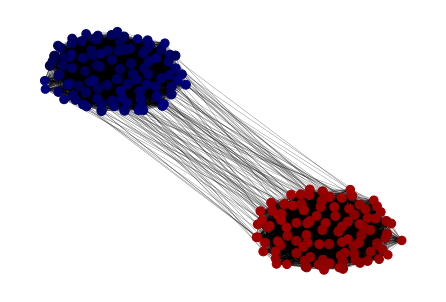

Bottleneck of G is 0.027295784924703657


In [7]:
# Plot Fiedler's vector over graph G (small Gap)
LG = nx.normalized_laplacian_matrix(G)
eG, evecsG = find_eigen(LG.todense())
degreeG = list(dict(G.degree).values())
posG = plot_eigenvector_over_graph(G,evecsG,1, node_size=degreeG)
print("Bottleneck of G is", eG[1])

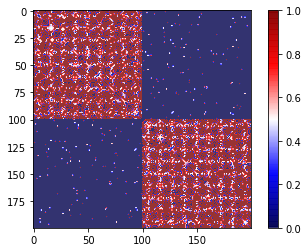

In [8]:
plt.imshow(A.todense(), alpha=0.8, cmap="seismic")
plt.colorbar()

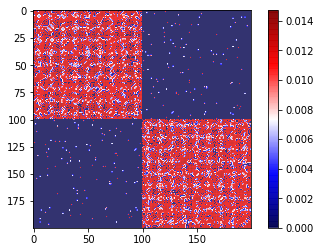

In [9]:
plt.imshow(T_sym.todense(), alpha=0.8, cmap="seismic")
plt.colorbar()

0.008049369752155646 0.0007336099045270586
0.0007501333514722313 0.007024329612997489
[0.11525549 0.10694653 0.10851289 0.10894909 0.1090763  0.10919292
 0.10204049 0.10646724 0.10511375 0.10658967 0.11089844 0.1094984
 0.10799502 0.10773622 0.11301968 0.11074156 0.10746696 0.10919085
 0.11147571 0.10853201 0.10892342 0.1086411  0.11181227 0.11332114
 0.10545855 0.10975782 0.11251509 0.10581627 0.1060776  0.10854194
 0.10596054 0.1073475  0.1092227  0.1078687  0.10671624 0.11018186
 0.10596022 0.10837636 0.10695372 0.10908283 0.10570319 0.10936297
 0.11445711 0.11048106 0.10864196 0.11018236 0.10596605 0.10959028
 0.11145358 0.10681731 0.1103197  0.10960853 0.11072289 0.10608854
 0.10721419 0.10961696 0.11662202 0.10581699 0.11251992 0.1075849
 0.10760921 0.10609626 0.10963227 0.11180716 0.10746586 0.10595737
 0.11001535 0.10733894 0.10760531 0.10658377 0.10672312 0.10693335
 0.10438989 0.10810246 0.10748078 0.1052149  0.10622786 0.11007754
 0.10865104 0.10561351 0.10596012 0.10975951 

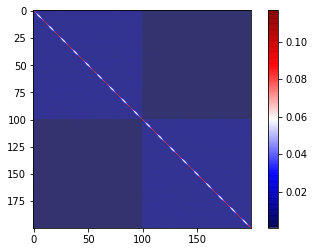

In [10]:
# T_S is a stochastic matrix
plt.imshow(T_S, alpha=0.8, cmap="seismic")
plt.colorbar()
print(T_S[0,10], T_S[0,150])
print(T_S[150,10], T_S[150,160])
print(np.diag(T_S))

In [11]:
# Get intra and inter edges magnitudes of T_S for latter thresholding 
# Partition
S = set([x for x in range(sizes[0])])
notS = set([x for x in range(sizes[0], 2*sizes[0])])

#Intra-class magnitudes
T_S_intra_S = get_intra_edges_magnitude(T_S,S)
print(len(T_S_intra_S))
T_S_intra_notS = get_intra_edges_magnitude(T_S,notS)
print(len(T_S_intra_notS))
T_S_intra = list()
for i in range(len(T_S_intra_S)):
  T_S_intra.append(T_S_intra_S[i])
for i in range(len(T_S_intra_notS)):
  T_S_intra.append(T_S_intra_notS[i])

# Inter-class magnitudes 
T_S_inter = get_inter_edges_magnitude(T_S,S,notS)
print(len(T_S_inter))

4950
4950
10000


In [12]:
# Edge magnitude Distributions (intra vs inter)
# Using seaborn
import pandas as pd
import seaborn as sns

MagGIntra = T_S_intra
print(MagGIntra)
MagGInter = T_S_inter
print(MagGInter)

df_intraG = pd.DataFrame(list(zip(MagGIntra,['Intra']*len(MagGIntra))), columns=['Magnitude', 'Edge Type'])
df_interG = pd.DataFrame(list(zip(MagGInter,['Inter']*len(MagGInter))), columns=['Magnitude', 'Edge Type'])
df_mag = pd.concat([df_intraG, df_interG]).reset_index()

[0.006791180005002174, 0.00792438022567274, 0.007835397253700286, 0.00790293953659067, 0.00796118904724576, 0.007701822229765046, 0.007900996893600756, 0.007950195169036391, 0.007942444600962257, 0.008049369752155646, 0.006662548429851425, 0.007891291959523596, 0.007766839203263332, 0.007932656567188435, 0.007980480688349558, 0.007922378948961199, 0.006749024758838934, 0.006731841116446164, 0.006738240650978168, 0.006599383531458018, 0.008016786350251074, 0.007949306871354755, 0.006730342165151835, 0.00784713101742952, 0.007994155287082288, 0.008014617947444375, 0.007787659620618932, 0.00792248354418136, 0.006728938895645602, 0.0067537445995538015, 0.007867424018396121, 0.006796635202772943, 0.007846126916483925, 0.006573559776414457, 0.007931933873838516, 0.00788931249841303, 0.007860330746273207, 0.007913447322742812, 0.006716770077476007, 0.00772837626208419, 0.007801604265121696, 0.00801865315152014, 0.006548428209580631, 0.007962074362146737, 0.007945316098089772, 0.00674242061685

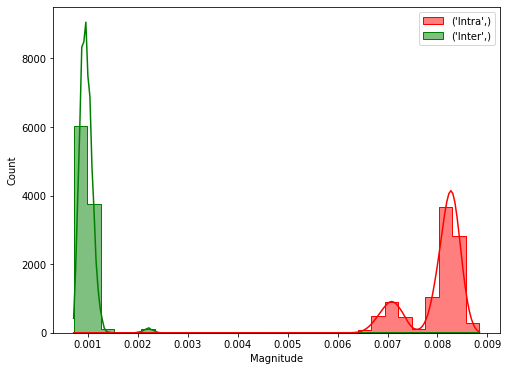

In [13]:
style = {'bins':30, 'kde':True, 'element':"step"}
plt.figure(figsize=(8,6))
sns.histplot(data=df_mag, x='Magnitude', hue=df_mag[['Edge Type']].apply(tuple, axis=1), alpha=0.5, palette=["r", "g"], **style)
plt.show()

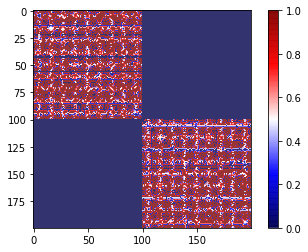

In [14]:
# Threshold T_S graph
T_S_zeroD = T_S.copy()
for i in range(G.number_of_nodes()):
  T_S_zeroD[i,i] = 0.0
T_S_th = T_S_zeroD>0.008
plt.imshow(T_S_th, alpha=0.8, cmap="seismic")
plt.colorbar()
GT_S_th = nx.from_numpy_array(T_S_th)

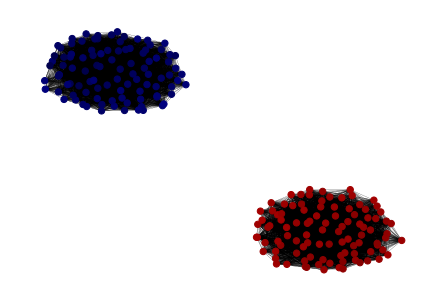

In [15]:
posGT_S_th = plot_eigenvector_over_graph(GT_S_th,evecsG,1, pos = posG)

In [16]:
# Cheeger constant h_S_alpha
S = set([x for x in range(sizes[0])])
notS = set([x for x in range(sizes[0], 2*sizes[0])])
hS_alpha = partition_cheeger(T_S_th,S,notS)
print("Cheeger constant hS_alfa", hS_alpha)

Cheeger constant hS_alfa 0.0


In [17]:
# Spectral gap of T_S
eT_S, evecsT_S = find_eigen(T_S)
n = G.number_of_nodes()
#print(eT_S)
#print(evecsT_S[:,n-1])
gapT_S = 1.0-eT_S[n-2]
print(gapT_S)

0.1950571384379386


In [18]:
# Cheeger constant h_S
S = set([x for x in range(sizes[0])])
notS = set([x for x in range(sizes[0], 2*sizes[0])])
hS = partition_cheeger(A.todense(),S,notS)
print("Cheeger constant h_S", hS)

Cheeger constant h_S 0.014010507880910683


In [19]:
# Spectral gap of L 
LG = nx.normalized_laplacian_matrix(G)
eLG, evecsLG = find_eigen(LG.todense())
gapLG = eLG[1]
print(gapLG)

0.027295784924703657


<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [20]:
G

## Curvature-based Rewiring

In [21]:
COLLAB_ENV = True #set to false if you are running it locally

import os
import torch

if COLLAB_ENV:
    !git clone https://github.com/ellisalicante/GraphRewiring-Tutorial
    !cd GraphRewiring-Tutorial && git submodule update --init --recursive
    !mv GraphRewiring-Tutorial/* ./
    !rm -rf GraphRewiring-Tutorial
    
    os.environ['TORCH'] = torch.__version__
    print(torch.__version__)
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

#add DiffWire to path to dynamically import
import sys
sys.path.append("./DiffWire")

Cloning into 'GraphRewiring-Tutorial'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 13), reused 23 (delta 6), pack-reused 0
Unpacking objects: 100% (35/35), done.
Submodule 'DiffWire' (https://github.com/AdrianArnaiz/DiffWire/) registered for path 'DiffWire'
Cloning into '/content/GraphRewiring-Tutorial/DiffWire'...
Submodule path 'DiffWire': checked out '5aded812451639187680c2d70bf16f4d2f21ca2e'
mv: cannot move 'GraphRewiring-Tutorial/DiffWire' to './DiffWire': Directory not empty
mv: cannot move 'GraphRewiring-Tutorial/figs' to './figs': Directory not empty
1.13.0+cu116


In [22]:
#from torch._C import float64
import math
from numba import cuda
import numpy as np
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
    to_dense_adj,
    remove_self_loops,
    to_undirected,
)

def softmax(a, tau=1):
    exp_a = np.exp(a * tau)
    return exp_a / exp_a.sum()


@cuda.jit(
    "void(float32[:,:], float32[:,:], float32[:], float32[:], int32, float32[:,:])"
)
def _balanced_forman_curvature(A, A2, d_in, d_out, N, C):
    i, j = cuda.grid(2)

    if (i < N) and (j < N):
        if A[i, j] == 0:
            C[i, j] = 0
            return

        if d_in[i] > d_out[j]:
            d_max = d_in[i]
            d_min = d_out[j]
        else:
            d_max = d_out[j]
            d_min = d_in[i]

        if d_max * d_min == 0:
            C[i, j] = 0
            return

        sharp_ij = 0
        lambda_ij = 0
        for k in range(N):
            TMP = A[k, j] * (A2[i, k] - A[i, k]) * A[i, j]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

            TMP = A[i, k] * (A2[k, j] - A[k, j]) * A[i, j]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

        C[i, j] = (
            (2 / d_max) + (2 / d_min) - 2 + (2 / d_max + 1 / d_min) * A2[i, j] * A[i, j]
        )
        if lambda_ij > 0:
            C[i, j] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_curvature(A, C=None):
    N = A.shape[0]
    A2 = torch.matmul(A, A)
    d_in = A.sum(axis=0)
    d_out = A.sum(axis=1)
    if C is None:
        C = torch.zeros(N, N).cuda()

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(N / threadsperblock[0])
    blockspergrid_y = math.ceil(N / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    _balanced_forman_curvature[blockspergrid, threadsperblock](A, A2, d_in, d_out, N, C)
    return C


@cuda.jit(
    "void(float32[:,:], float32[:,:], float32, float32, int32, float32[:,:], int32, int32, int32[:], int32[:], int32, int32)"
)
def _balanced_forman_post_delta(
    A, A2, d_in_x, d_out_y, N, D, x, y, i_neighbors, j_neighbors, dim_i, dim_j
):
    I, J = cuda.grid(2)

    if (I < dim_i) and (J < dim_j):
        i = i_neighbors[I]
        j = j_neighbors[J]

        if (i == j) or (A[i, j] != 0):
            D[I, J] = -1000
            return

        # Difference in degree terms
        if j == x:
            d_in_x += 1
        elif i == y:
            d_out_y += 1

        if d_in_x * d_out_y == 0:
            D[I, J] = 0
            return

        if d_in_x > d_out_y:
            d_max = d_in_x
            d_min = d_out_y
        else:
            d_max = d_out_y
            d_min = d_in_x

        # Difference in triangles term
        A2_x_y = A2[x, y]
        if (x == i) and (A[j, y] != 0):
            A2_x_y += A[j, y]
        elif (y == j) and (A[x, i] != 0):
            A2_x_y += A[x, i]

        # Difference in four-cycles term
        sharp_ij = 0
        lambda_ij = 0
        for z in range(N):
            A_z_y = A[z, y] + 0
            A_x_z = A[x, z] + 0
            A2_z_y = A2[z, y] + 0
            A2_x_z = A2[x, z] + 0

            if (z == i) and (y == j):
                A_z_y += 1
            if (x == i) and (z == j):
                A_x_z += 1
            if (z == i) and (A[j, y] != 0):
                A2_z_y += A[j, y]
            if (x == i) and (A[j, z] != 0):
                A2_x_z += A[j, z]
            if (y == j) and (A[z, i] != 0):
                A2_z_y += A[z, i]
            if (z == j) and (A[x, i] != 0):
                A2_x_z += A[x, i]

            TMP = A_z_y * (A2_x_z - A_x_z) * A[x, y]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

            TMP = A_x_z * (A2_z_y - A_z_y) * A[x, y]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

        D[I, J] = (
            (2 / d_max) + (2 / d_min) - 2 + (2 / d_max + 1 / d_min) * A2_x_y * A[x, y]
        )
        if lambda_ij > 0:
            D[I, J] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_post_delta(A, x, y, i_neighbors, j_neighbors, D=None):
    N = A.shape[0]
    A2 = torch.matmul(A, A)
    d_in = A[:, x].sum()
    d_out = A[y].sum()
    if D is None:
        D = torch.zeros(len(i_neighbors), len(j_neighbors)).cuda()

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(D.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(D.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    _balanced_forman_post_delta[blockspergrid, threadsperblock](
        A,
        A2,
        d_in,
        d_out,
        N,
        D,
        x,
        y,
        np.array(i_neighbors),
        np.array(j_neighbors),
        D.shape[0],
        D.shape[1],
    )
    return D


def sdrf(
    data,
    loops=10,
    remove_edges=True,
    removal_bound=0.6, # default 0.5
    tau=1, # default 1
    is_undirected=True,
):
    G = data
    A = nx.adjacency_matrix(G)
    A = torch.tensor(A.toarray(), dtype = torch.float).fill_diagonal_(0)
    N = A.shape[0]
    
    if is_undirected:
        G = G.to_undirected()
        #G = G.to_directed()
    A = A.cuda()
    C = torch.zeros(N, N).cuda()

    for x in range(loops):
        can_add = True
        balanced_forman_curvature(A, C=C)
        ix_min = C.argmin().item()
        x = ix_min // N
        y = ix_min % N
        
        if is_undirected:
            x_neighbors = list(G.neighbors(x)) + [x]
            y_neighbors = list(G.neighbors(y)) + [y]
        else:
            x_neighbors = list(G.successors(x)) + [x]
            y_neighbors = list(G.predecessors(y)) + [y]
        candidates = []
        for i in x_neighbors:
            for j in y_neighbors:
                if (i != j) and (not G.has_edge(i, j)):
                    candidates.append((i, j))

        if len(candidates):
            D = balanced_forman_post_delta(A, x, y, x_neighbors, y_neighbors)
            improvements = []
            for (i, j) in candidates:
                improvements.append(
                    (D - C[x, y])[x_neighbors.index(i), y_neighbors.index(j)].item()
                )

            k, l = candidates[
                np.random.choice(
                    range(len(candidates)), p=softmax(np.array(improvements), tau=tau)
                )
            ]
            G.add_edge(k, l)
            if is_undirected:
                A[k, l] = A[l, k] = 1
            else:
                A[k, l] = 1
        else:
            can_add = False
            if not remove_edges:
                break

        if remove_edges:
            ix_max = C.argmax().item()
            x = ix_max // N
            y = ix_max % N
            if C[x, y] > removal_bound:
                G.remove_edge(x, y)
                if is_undirected:
                    A[x, y] = A[y, x] = 0
                else:
                    A[x, y] = 0
            else:
                if can_add is False:
                    break

    return G


<ipython-input-22-4a4afd477225>:200: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 36 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.8/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


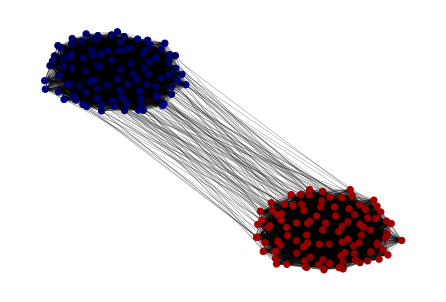

<ipython-input-23-78e53417153e>:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ahat = nx.adjacency_matrix(Ghat)


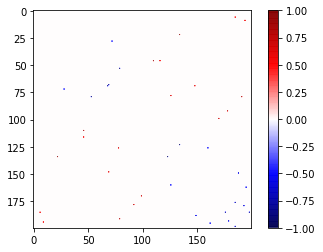

In [23]:
Ghat = sdrf(G)
posGhat = plot_eigenvector_over_graph(Ghat,evecsG,1, pos = posG)
Ahat = nx.adjacency_matrix(Ghat)
plt.imshow(Ahat.todense()-A.todense(), alpha=0.8, cmap="seismic")
plt.colorbar()

In [24]:
# Cheeger constant h_S
S = set([x for x in range(sizes[0])])
notS = set([x for x in range(sizes[0], 2*sizes[0])])
hGhat = partition_cheeger(Ahat,S,notS)
print("Cheeger constant", hGhat)

Cheeger constant 0.015253813453363341


In [25]:
# h of the original graph is 0.014010507880910683
# removal_bound=0.5: h = 0.015261446084563422
# removal_bound=0.6  h = 0.015261446084563422
# removal_bound=0.8 only adds edges but h = 0.015261446084563422

In [26]:
# Spectral gap of L 
LGhat = nx.normalized_laplacian_matrix(Ghat)
eLGhat, evecsLGhat = find_eigen(LGhat.todense())
gapLGhat = eLGhat[1]
print(gapLGhat)
print(gapLG)

0.029757021665800482
0.027295784924703657


<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [27]:
# Degree Distributions
# Using seaborn
import pandas as pd
import seaborn as sns

degG = list(degree_vector(A))
print(degG)
degGth = list(degree_vector(T_S_th))
print(degGth)
degGhat = list(degree_vector(Ahat))
print(degGhat)


df_degG = pd.DataFrame(list(zip(degG,['G']*len(degG))), columns=['Degree', 'Graph'])
df_degGth = pd.DataFrame(list(zip(degGth,['Gth']*len(degGhat))), columns=['Degree', 'Graph'])
df_degGhat = pd.DataFrame(list(zip(degGhat,['Ghat']*len(degGhat))), columns=['Degree', 'Graph'])
df_deg = pd.concat([df_degG, df_degGth, df_degGhat]).reset_index()

[69.0, 83.0, 80.0, 79.0, 79.0, 79.0, 93.0, 84.0, 87.0, 84.0, 76.0, 78.0, 81.0, 81.0, 72.0, 76.0, 82.0, 79.0, 75.0, 80.0, 79.0, 80.0, 74.0, 72.0, 86.0, 78.0, 73.0, 85.0, 85.0, 80.0, 85.0, 82.0, 79.0, 81.0, 83.0, 77.0, 85.0, 80.0, 83.0, 79.0, 85.0, 78.0, 70.0, 76.0, 80.0, 77.0, 85.0, 78.0, 75.0, 83.0, 77.0, 78.0, 76.0, 85.0, 82.0, 78.0, 67.0, 85.0, 73.0, 82.0, 82.0, 85.0, 78.0, 74.0, 82.0, 85.0, 77.0, 82.0, 82.0, 84.0, 83.0, 83.0, 88.0, 81.0, 82.0, 86.0, 84.0, 77.0, 80.0, 86.0, 85.0, 78.0, 81.0, 83.0, 79.0, 73.0, 80.0, 78.0, 78.0, 75.0, 76.0, 72.0, 76.0, 83.0, 82.0, 75.0, 75.0, 81.0, 86.0, 84.0, 74.0, 86.0, 72.0, 79.0, 78.0, 85.0, 68.0, 83.0, 88.0, 76.0, 75.0, 82.0, 80.0, 78.0, 77.0, 80.0, 76.0, 76.0, 77.0, 79.0, 85.0, 79.0, 79.0, 86.0, 79.0, 82.0, 86.0, 75.0, 75.0, 74.0, 84.0, 86.0, 80.0, 84.0, 83.0, 85.0, 78.0, 83.0, 78.0, 73.0, 77.0, 78.0, 72.0, 86.0, 83.0, 73.0, 82.0, 85.0, 82.0, 84.0, 74.0, 84.0, 76.0, 79.0, 84.0, 84.0, 82.0, 86.0, 79.0, 82.0, 85.0, 76.0, 87.0, 82.0, 79.0, 79.0, 80.

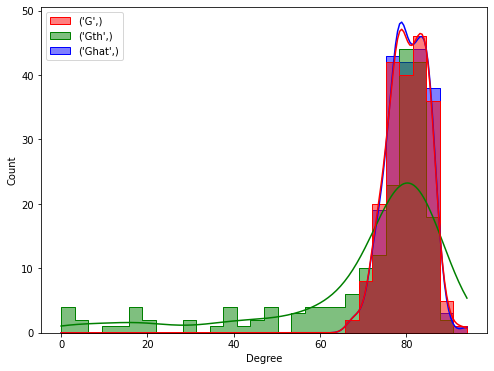

In [28]:
style = {'bins':30, 'kde':True, 'element':"step"}
plt.figure(figsize=(8,6))
sns.histplot(data=df_deg, x='Degree', hue=df_deg[['Graph']].apply(tuple, axis=1), alpha=0.5, palette=["r", "g", "b"], **style)
plt.show()